In [1]:
import torch
import sys
import os
sys.path.append('../vega/')
import vega
import scanpy as sc
import scvi
from scipy import sparse
import numpy as np
import gseapy as gp
import pandas as pd
torch.manual_seed(0)
np.random.seed(0)

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
path_to_save = '../paper/figures/inference_generalizability/'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
font = {'family' : 'Arial',
        'size'   : 14}
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.linewidth'] = .5
matplotlib.rcParams['lines.linewidth'] = .5
matplotlib.rcParams['patch.linewidth'] = .5
matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
# Scanpy figures params
sc.set_figure_params(dpi_save=300)
sc.settings.figdir = path_to_save

### Intra-dataset

In [2]:
# Load full data and CD4T out model
full_data = sc.read('../data/kang_pbmc.h5ad')
vega.utils.setup_anndata(full_data)
model = vega.VEGA.load('../trained_models/vega_ct_out/vega_kang_pbmc_CD4T_out/')
full_data.obsm['X_vega'] = model.to_latent(full_data, return_mean=True)
pathway_encoded_df = pd.DataFrame(full_data.obsm['X_vega'],
                                  columns=model.adata.uns['_vega']['gmv_names'])

Running VEGA and SCVI setup...
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 18868 cells, 6998 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.


In [3]:
# Reload full model
model_full = vega.VEGA.load('../trained_models/kang_vega/')

Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.


In [4]:
# Sample random CD4 stim , random CD4 control, encode in both model and compare distribution of IFN
n_sample = 10000
idx_cd4_stim = np.random.choice(np.arange(len(full_data))[(full_data.obs['cell_type'] == 'CD4T') & (full_data.obs['condition'] == 'stimulated')], n_sample)
idx_cd4_ctrl = np.random.choice(np.arange(len(full_data))[(full_data.obs['cell_type'] == 'CD4T') & (full_data.obs['condition'] == 'control')], n_sample)
z_out = np.vstack((model.to_latent(full_data, indices=idx_cd4_ctrl, return_mean=True),
                  model.to_latent(full_data, indices=idx_cd4_stim, return_mean=True)))
z_all = np.vstack((model_full.to_latent(full_data, indices=idx_cd4_ctrl, return_mean=True),
                  model_full.to_latent(full_data, indices=idx_cd4_stim, return_mean=True)))

In [5]:
pathway_encoded_df = pd.DataFrame(data=np.vstack((z_out,z_all)),
                                  index=np.arange(4*n_sample),
                                  columns=model.adata.uns['_vega']['gmv_names'])
ifn_resp = pathway_encoded_df[['REACTOME_INTERFERON_ALPHA_BETA_SIGNALING']]

In [6]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

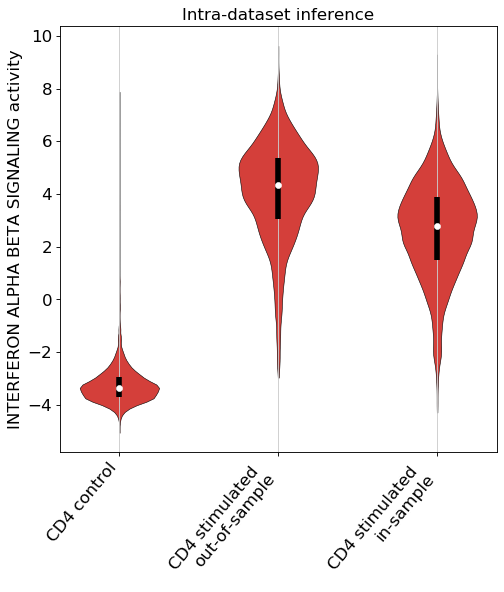

In [8]:
mat_box = np.array([ifn_resp['REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'][i*n_sample:(i+1)*n_sample].values for i in range(4) if i != 2]).T

fig, ax = plt.subplots(figsize=[7,7])
plt.grid(axis='y')
box = ax.violinplot(mat_box, showmeans=False, showmedians=False,
        showextrema=False)
for pc in box['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile(mat_box, [25, 50, 75], axis=0)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(mat_box, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
#ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)


plt.ylabel('INTERFERON ALPHA BETA SIGNALING activity', fontsize=15)
plt.xticks(range(1, mat_box.shape[1]+1), ['CD4 control', 'CD4 stimulated \nout-of-sample', 'CD4 stimulated \nin-sample'], rotation=50, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.title('Intra-dataset inference', fontsize=15)
#plt.savefig(path_to_save+'intra_inference.pdf', format='pdf', dpi=300, bbox_inches='tight')

### Inter-dataset

In [9]:
adata_zheng = sc.read('../../data/zheng_3k_hvg.h5ad')
cd4_zheng_X = adata_zheng.X.A[adata_zheng.obs['cell_type'] == 'CD4 T cells',:]
adata_cd4_stim = full_data.copy()[((full_data.obs['cell_type'] == 'CD4T') & (full_data.obs['condition'] == 'stimulated'))]
cd4_stim_X = adata_cd4_stim.X.A[np.random.choice(np.arange(len(adata_cd4_stim)), 2000),:]
adata_cd4_ctrl = full_data.copy()[((full_data.obs['cell_type'] == 'CD4T') & (full_data.obs['condition'] == 'control'))]
cd4_ctrl_X = adata_cd4_ctrl.X.A[np.random.choice(np.arange(len(adata_cd4_ctrl)), 2000),:]
#randomly sample 2000 cells
cd4_zheng_X = cd4_zheng_X[np.random.choice(np.arange(len(cd4_zheng_X)), 2000), :]

cd4_studies_all = np.vstack((cd4_ctrl_X, cd4_stim_X, cd4_zheng_X))

In [10]:
adata_studies = sc.AnnData(X=cd4_studies_all,
                           obs=pd.DataFrame(index=np.arange(len(cd4_studies_all)),
                                            data=np.array(['Kang']*4000 + ['Zheng']*2000),
                                            columns=['Study']))
vega.utils.setup_anndata(adata_studies)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Running VEGA and SCVI setup...
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 6000 cells, 6998 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [11]:
z_studies = model_full.to_latent(adata_studies, return_mean=True)
pathway_studies = pd.DataFrame(data=z_studies,
                               index=np.arange(cd4_studies_all.shape[0]),
                               columns=model.adata.uns['_vega']['gmv_names'])
ifn_resp_studies = pathway_studies[['REACTOME_INTERFERON_ALPHA_BETA_SIGNALING']]

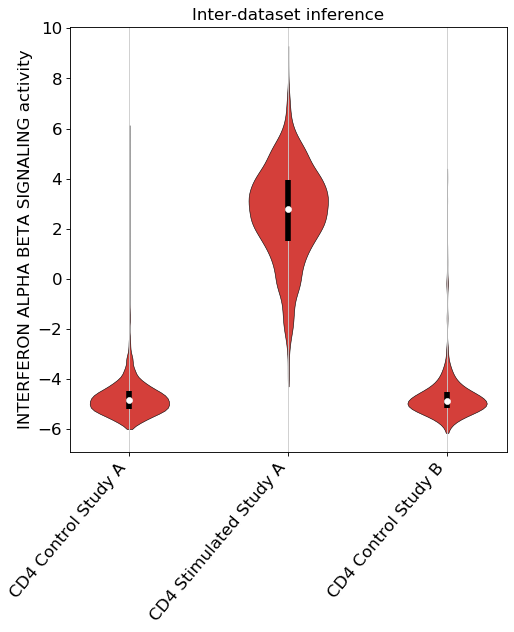

In [13]:
mat_box = np.array([ifn_resp_studies['REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'][i*2000:(i+1)*2000].values for i in range(3)]).T

fig, ax = plt.subplots(figsize=[7,7])
plt.grid(axis='y')
box = ax.violinplot(mat_box, showmeans=False, showmedians=False,
        showextrema=False)
for pc in box['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile(mat_box, [25, 50, 75], axis=0)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(mat_box, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
#ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)


plt.ylabel('INTERFERON ALPHA BETA SIGNALING activity', fontsize=15)
plt.xticks(range(1, mat_box.shape[1]+1), ['CD4 Control Study A', 'CD4 Stimulated Study A', 'CD4 Control Study B'], rotation=50, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.title('Inter-dataset inference', fontsize=15)
#plt.savefig(path_to_save+'inter_inference.pdf', format='pdf', dpi=300, bbox_inches='tight')